In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# import skimage
import skimage.io as io
from skimage import transform as tf
from skimage.transform import resize

from scipy import ndimage, fftpack

%matplotlib inline
from ipywidgets import interact, fixed

# Image processing

A guide step by step to learn to process the images.

In [2]:
IMDIR = "./Images" # "./Replace/With/Your/Filepath"
# imagename = "einstein.jpg"
# filename = os.path.join(IMDIR, imagename)

# im = io.imread(filename, as_gray=True)
           
# The following lines control how big the images are shown on the screen
width = 15
height = 5
plt.rcParams['figure.figsize'] = [width, height]

Read and display the images in the provided folder

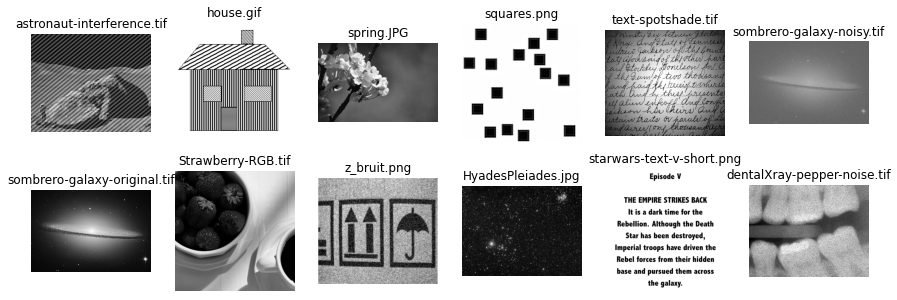

In [3]:
#  create a figure
fig = plt.figure()

# look for all available image files in IMDIR
im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        
        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):

            im = io.imread(f,as_gray=True)
            
            if im_counter > 12: #showing maximum 25 images
                break
                
            # display it
            plt.subplot(2,6,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1 
            
plt.show()

## 0 General properties

In [4]:
SUBDIR = os.path.join(IMDIR, "general")

Luminance

In [5]:
# Compute the luminance of an image
def luminance(im):
    if len(im.shape) == 2: # if grayscale, values in range(0,1)
        h, w = im.shape
        luminance = np.sum(im)/(h*w)
        return luminance
    
    elif len(im.shape) == 3: # if RGB, values in range(0,255)
        h, w, _ = im.shape
        R = im[:,:,0]
        G = im[:,:,1]
        B = im[:,:,2]
            
        luminance = (0.299*np.sum(R) + 0.587*np.sum(G) + 0.114*np.sum(B)) /(h*w)
        return luminance
    
    else:
        raise ValueError('It is not a supported image format')

Contrast

In [6]:
# compute the contrast of an image
def contrast(im):
    if len(im.shape) == 2: # if grayscale
        h, w = im.shape
    elif len(im.shape) == 3: # if RGB
        h, w, _ = im.shape
    else:
        raise ValueError('It is not a supported image format')
    
    # contrast = (np.max(im)-np.min(im))/(np.max(im)+np.min(im))
    contrast = np.sqrt((1/(h*w) * np.sum((im-luminance(im))**2)))
    return contrast

Histogram and cummulative histogram

In [7]:
def histo(im, bins=255):
    hist, bin_edges = np.histogram(im, bins)
    bin_values = (bin_edges[:-1] + bin_edges[1:]) / 2
    cum_hist = np.cumsum(hist)
    
    plt.subplot(121)
    plt.plot(bin_values, hist)
    plt.title('Histogram')
    plt.subplot(122)
    plt.plot(bin_values, cum_hist)
    plt.title('Cummulative histogram')
    plt.show()

    return hist, cum_hist, bin_values

PSNR: Peak SNR

Typical values for the PSNR in lossy image are between 30 and 50 dB, where higher is better.

In [8]:
def psnr(im_ori, im_noise):
    if im_ori.shape != im_noise.shape:
        raise ValueError('Two images do not match')
    
    if len(im_ori.shape) == 2: # if grayscale
        h, w = im_ori.shape

    elif len(im_ori.shape) == 3: # if RGB
        h, w, _ = im_ori.shape
    else:
        raise ValueError('It is not a supported image format')
    
    mse = np.sum((im_ori - im_noise)**2)/(h*w) # mean square error
    psnr = 20*np.log10(im_ori.max()) - 10*np.log10(mse)
    return psnr

Test of functions

In [9]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

# plt.imshow(im, cmap='gray')
# plt.show()

# print(luminance(im))
# print(contrast(im))
# _, _, _ = histo(im)

# PSNR GALAXY
imagename = "sombrero-galaxy-original.tif"
filename = os.path.join(SUBDIR, imagename)
im_origi = io.imread(filename, as_gray=True)

imagename = "sombrero-galaxy-noisy.tif"
filename = os.path.join(SUBDIR, imagename)
im_noisy = io.imread(filename, as_gray=True)

print('psnr = ', psnr(im_origi, im_noisy))


psnr =  27.666217440866628


## 1 Intensity Transformations

In [10]:
def color2gray(im):
    return np.dot(im[...,0:3], [0.2989, 0.5870, 0.1140])

def gray2threshold(im, k):
    im_threshold = np.where(im < k, 0, 1)
    return im_threshold

def linear(im, a=4, b=0):
    return a*im + b

def invert(im):
    return im.max() + im.min() - im

def gamma(im, c=1, gamma=0.5):
    return c*im**gamma

def logtf(im):
    c = 255 / np.log(1 + im.max())
    return c * np.log(im + 1)

# we can also import them directly
# skimage.color.rgb2gray(im)
# skimage.exposure.adjust_gamma(image[, ...])
# skimage.exposure.adjust_log(image[, gain, inv])
# skimage.exposure.equalize_hist(img)

Test function

In [11]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1


@interact(k = (0, 1, 0.01))
def show_threshold(k):
    plt.imshow(gray2threshold(im, k), cmap='gray')
    plt.show()
    return

interactive(children=(FloatSlider(value=0.0, description='k', max=1.0, step=0.01), Output()), _dom_classes=('w…

## 2 Morphological Operations

* For binary images, it is obvious because 0 is none(black) and 1 is present(white).
* For grayscale images, the erision/dilation of a pixel is defined by the smallest/largest grayscale contained in the structuring element.\
[Demostration of erosion](https://en.wikipedia.org/wiki/Erosion_(morphology)#/media/File:Grayscale_Morphological_Erosion.gif), 
[Demostration of dilation](https://en.wikipedia.org/wiki/Dilation_(morphology)#/media/File:Grayscale_Morphological_Dilation.gif)

In [12]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk, square, diamond, star

# creat different structuring elements
selem_disk = disk(5) # radius
selem_sq = square(8)
selem_diam = diamond(4)
selem_star = star(3)

Interactive way

In [13]:
imagename = "z_bruit.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

operation_map = {
    'erosion': erosion,
    'dilation': dilation,
    'opening': opening,
    'closing': closing,
    }

struc_elem_map = {
    'disk': disk,
    'square': square,
    'diamond': diamond,
    'star': star,
    }

def morphology(im, operation_name, struc_elem, r=5):
    if operation_name == 'original':
        plt.imshow(im, cmap='gray')
    else:
        selem = struc_elem_map[struc_elem](r)
        im = operation_map[operation_name](im, selem)
        plt.imshow(im, cmap='gray')
    plt.show()
    return

interact(
    morphology, 
    im = fixed(im),
    operation_name = ['original','erosion','dilation','opening','closing'], 
    struc_elem = ['disk','square','diamond','star'], 
    r=(0,10,1)
)

interactive(children=(Dropdown(description='operation_name', options=('original', 'erosion', 'dilation', 'open…

<function __main__.morphology(im, operation_name, struc_elem, r=5)>

Basic comparision

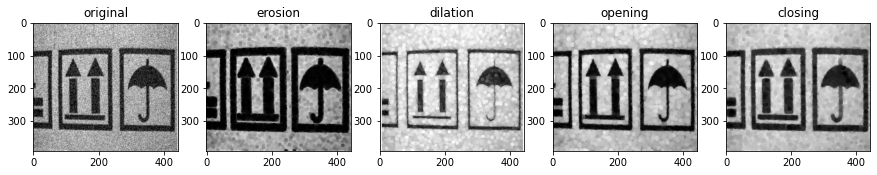

In [14]:
imagename = "z_bruit.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

im_counter = 1

plt.subplot(1,5,im_counter)
plt.imshow(im, cmap='gray')
plt.title('original')
im_counter +=1 

# erosion
eroded_im = erosion(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(eroded_im, cmap='gray')
plt.title('erosion')
im_counter +=1 

# dilation
dilated_im = dilation(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(dilated_im, cmap='gray')
plt.title('dilation')
im_counter +=1 

# opening
opened_im = opening(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(opened_im, cmap='gray')
plt.title('opening')
im_counter +=1 

# closing
closed_im = closing(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(closed_im, cmap='gray')
plt.title('closing')
im_counter +=1 

## 3 Spatial filtering

In [15]:
SUBDIR = os.path.join(IMDIR, "spatial_filter")

Kernal

In [16]:
def meanKernel(hs):
    kernel = np.zeros((hs*2+1,hs*2+1))
    kernel += 1/(hs*2+1)**2
    return kernel

def gaussianKernel(hs,sigma=1):
    u = hs*2+1
    v = hs*2+1
    kernel = np.zeros((u,v))
    for i in np.arange(u):
        for j in np.arange(v):
            kernel[i,j] = 1/(2*np.pi*sigma**2)*np.exp(-((i-hs)**2+(j-hs)**2)/(2*sigma**2))
    kernel = kernel/np.sum(kernel) # make sure sum=1 when discret
    return kernel

def xGradientkernel():
    kernel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    return kernel
def yGradientkernel():
    kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    return kernel
def laplaciankernel():
    kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    # kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    return kernel

Test convolution with Kernel

In [17]:
imagename = "face.jpg"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

kernel_map = {
    'mean': meanKernel,
    'gaussian': gaussianKernel,
    'x_gradient': xGradientkernel,
    'y_gradient': yGradientkernel,
    'laplacian': laplaciankernel,
    }

def spatial_filter(im, kernel_name, hs=3, sigma=1):
    if kernel_name == 'original':
        plt.imshow(im, cmap='gray')
        plt.show()
        return
    
    if kernel_name == 'mean':
        kernel = kernel_map[kernel_name](hs)
    elif kernel_name == 'gaussian':
        kernel = kernel_map[kernel_name](hs,sigma)
    else:
        try:
            kernel = kernel_map[kernel_name]()
        except KeyError:
            raise ValueError('Invalid kernal choice')

    im_filtered = ndimage.convolve(im, kernel)
    plt.imshow(im_filtered, cmap='gray')
    plt.show()
    return im_filtered

interact(
    spatial_filter, 
    im = fixed(im),
    kernel_name = ['original','mean','gaussian','x_gradient','y_gradient','laplacian'],
    hs = (0,8,1),
    sigma = (1e-10,3,0.01),
    )

interactive(children=(Dropdown(description='kernel_name', options=('original', 'mean', 'gaussian', 'x_gradient…

<function __main__.spatial_filter(im, kernel_name, hs=3, sigma=1)>

Image enhancement

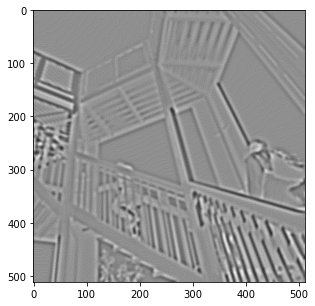

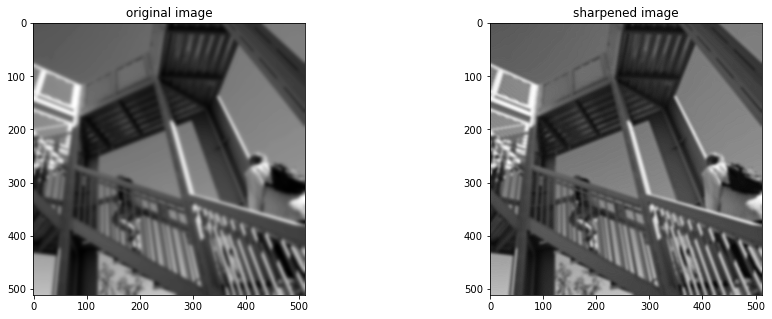

In [18]:
imagename = "stairs_blurred.png"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

c = -1 # depends on the central pixel of kernel, if positive then c=1
im_laplacian = spatial_filter(im, 'laplacian')
im_sharp = im + c*im_laplacian
im_sharp = im_sharp / np.max(im_sharp)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('original image')
plt.subplot(122)
plt.imshow(im_sharp, cmap='gray')
plt.title('sharpened image')
plt.show()

Denoising

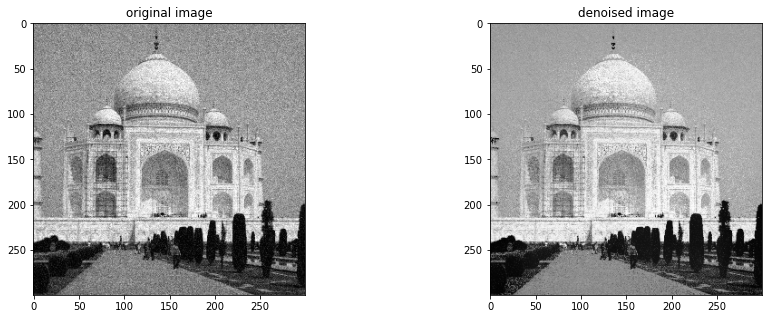

In [19]:
from skimage.restoration import denoise_bilateral

imagename = "taj_noisy.jpg"
filename = os.path.join(SUBDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('original image')

plt.subplot(122)
plt.imshow(denoise_bilateral(im, sigma_color=0.1, sigma_spatial=15), cmap='gray')
plt.title('denoised image')
plt.show()

## 4 Frequency analyse

DTF using some numpy's fft functions:

- ```np.fft.fft2```: computes the two-dimensional FFT of an image.
- ```np.fft.fftshift```: center the frecuencies in the middle of the image
- ```np.fft.ifftshift```: reverses the centering
- ```np.fft.ifft2```: inverse fourier transform
- ```np.real```: takes the real components of a complex number
- ```np.abs```: recovers the magnitude of a complex number
- ```np.angle```: recovers the phase of a complex number 
- ```np.log```: computes the logarithm

In [20]:
SUBDIR = os.path.join(IMDIR, "Fourier")

Show images and their fft

./Images\Fourier\astronaut-interference.tif


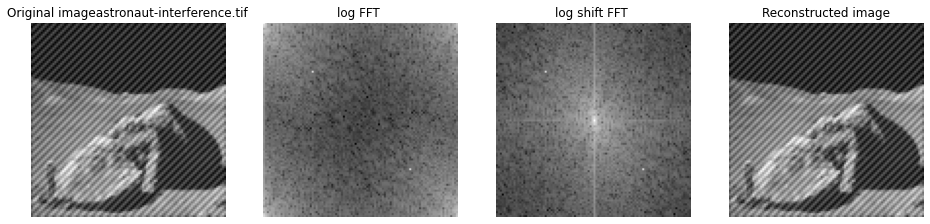

./Images\Fourier\house.gif


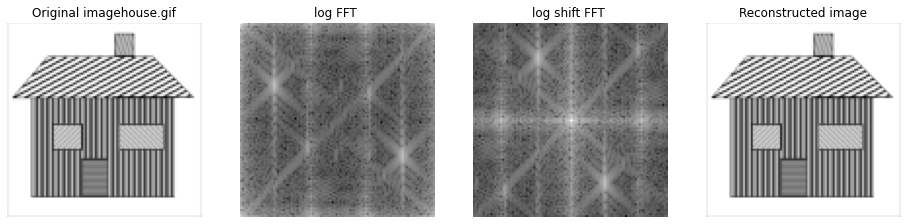

./Images\Fourier\spring.JPG


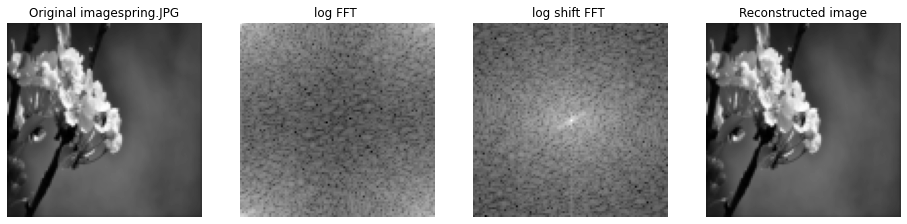

./Images\Fourier\squares.png


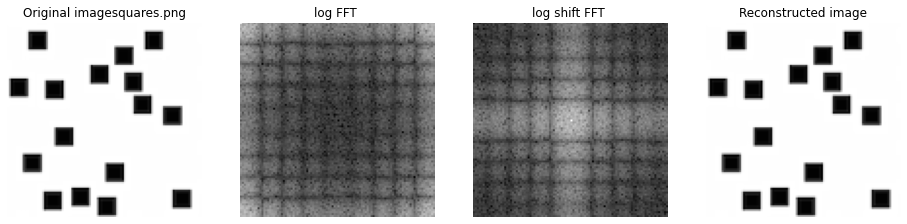

./Images\Fourier\text-spotshade.tif


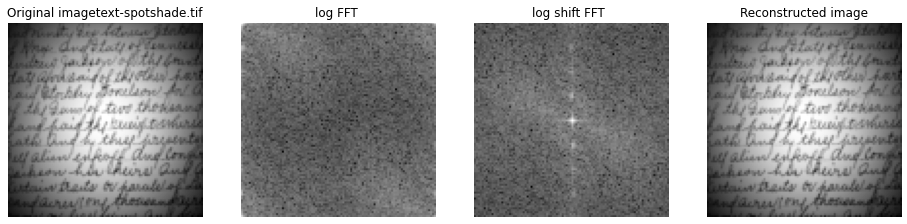

In [21]:
for root, dirnames, filenames in os.walk(SUBDIR):
    # print path to all filenames.
    for filename in filenames:
        f = os.path.join(root, filename)
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            print(f)
            im = io.imread(f,as_gray=True)
            im = resize(im,(100,100),mode='constant') # RESIZE IF TOO SLOW 
    
            
            # computing DFT
            im_fft2 = np.fft.fft2(im)
            im_fftshift = np.fft.fftshift(im_fft2)         
            im_ifft = np.fft.ifft2(np.fft.ifftshift(im_fftshift))

            
            fig = plt.figure(figsize=(16, 18))

            plt.subplot(141)
            plt.title('Original image'+filename)
            plt.imshow(im)
            plt.gray()
            plt.axis('off')

            
            plt.subplot(142)
            plt.title('log FFT ')
            plt.imshow(np.log(np.abs(im_fft2)))
            plt.gray()
            plt.axis('off')
                        
            plt.subplot(143)
            plt.title('log shift FFT ')
            plt.imshow(np.log(np.abs(im_fftshift)))
            plt.gray()
            plt.axis('off')
            
            plt.subplot(144)
            plt.title('Reconstructed image')
            plt.imshow(np.real(im_ifft)) # attention using real
            plt.gray()
            plt.axis('off')
            
            plt.show()

Filters in frequency domain

In [22]:
# D0: Cut-off Frequency (radius of the disk in the fft2)

# low pass filter
def lowPass(im, D0, filtertype):
    h, w = im.shape
    D = np.zeros((h,w))
    
    # DFT
    im_fft2 = np.fft.fftshift((np.fft.fft2(im)))
    
    # Should be created as complex, or the imaginary will be discharged
    im_filtered_fft = np.zeros((h,w), dtype=complex)

    for u in np.arange(h):
        for v in np.arange(w):
            D[u,v] = np.sqrt((u-h/2)**2 + (v-w/2)**2)
            
            # ideal filter
            if filtertype == "ideal": 
                im_filtered_fft[u,v] = (D[u,v] <= D0)*im_fft2[u,v]
            # gaussian filter
            elif filtertype == "gaussian": 
                im_filtered_fft[u,v] = np.exp(-(D[u,v]**2 / (2*D0**2))) *im_fft2[u,v]
            else:
                raise ValueError("Wrong filter type name")
    
    im_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(im_filtered_fft)))

    return im_filtered


In [23]:
# D0: Cut-off Frequency (radius of the disk in the fft2)

# high pass filter
def highPass(im, D0, filtertype):
    h, w = im.shape
    D = np.zeros((h,w))
    
    # DFT
    im_fft2 = np.fft.fftshift((np.fft.fft2(im)))
    
    # Should be created as complex, or the imaginary will be discharged
    im_filtered_fft = np.zeros((h,w), dtype=complex)

    for u in np.arange(h):
        for v in np.arange(w):
            D[u,v] = np.sqrt((u-h/2)**2 + (v-w/2)**2)
            
            # ideal filter
            if filtertype == "ideal": 
                im_filtered_fft[u,v] = (D[u,v] > D0)*im_fft2[u,v]
            # gaussian filter
            elif filtertype == "gaussian": 
                im_filtered_fft[u,v] = (1-np.exp(-(D[u,v]**2 / (2*D0**2)))) *im_fft2[u,v]
            else:
                raise ValueError("Wrong filter type name")
    
    im_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(im_filtered_fft)))

    return im_filtered

In [24]:
filter_map = {
    'Low Pass': lowPass,
    'High Pass': highPass,
}


@interact( 
    imagename = ['house.gif','squares.png','astronaut-interference.tif','text-spotshade.tif'],
    filtername = ['Low Pass','High Pass'],
    filtertype = ['ideal','gaussian'],
    D0 = (1e-10,50,1e-10),
    )
def show_fft2(imagename, filtername, filtertype, D0):
    filename = os.path.join(SUBDIR, imagename)
    im = io.imread(filename, as_gray=True)
    im = im/np.max(im) # normalize value range to 0~1
    im = resize(im,(200,200),mode='constant') # RESIZE IF TOO SLOW 

    im_filtered = filter_map[filtername](im, D0, filtertype)

    plt.subplot(121)
    plt.imshow(im, cmap='gray')
    plt.subplot(122)
    plt.imshow(im_filtered, cmap='gray')
    plt.show()
    return

interactive(children=(Dropdown(description='imagename', options=('house.gif', 'squares.png', 'astronaut-interf…

[JPEG compression](https://www.youtube.com/watch?v=Q2aEzeMDHMA)

One of the crucial steps of JPEG Compression is the quantization in frequency space. The procedure follows the next steps:

1. An image is first subdivided in 8x8 subblocks (assuming the original image has sides whose length is a multiple of 8, if it is not the case just resize it).

2. A frequency transformation is computed for each block (computed with a discrete cosine transform DCT II ) `fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')`

3. The DCT results are then divided by the elements of a predefined quantization matrix, then rounded and stored as integers.

4. The result of quantization (which should have many zeros) is then compressed Run Lenght Coding and Huffman coding to reduce the size. The compressed values are saved together with the quantization table.

5. The reconstruction of the image implies inverting the encoding, the quantization and the dct.

In [25]:
# compute discrete cosine transform DCT II
def dct_2d(im):
    return fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')

# compute inverse DCT II
def idct_2d(im):
    return fftpack.idct(fftpack.idct(im.T, norm='ortho').T, norm='ortho')


def quantization_table(component='lum'):
    # Quantization Table for: Photoshop 
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q

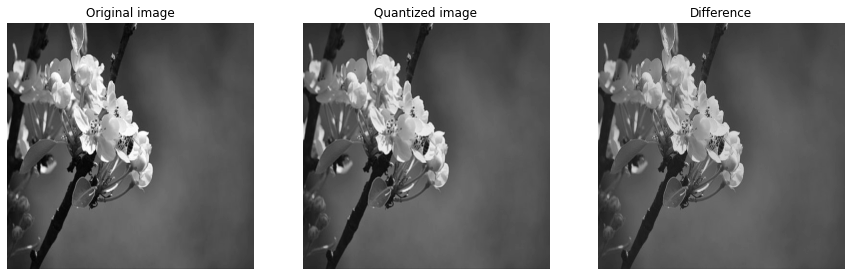

In [26]:
imagename = "spring.JPG"
filename = os.path.join(SUBDIR, imagename)

im = io.imread(filename, as_gray=True)
im = resize(im,(512,512), mode='constant') # RESIZE IMAGE HERE
im = im/np.max(im)*255 # IMPORTANT!!!

h,w = im.shape
im_restored = np.zeros(im.shape)
q = quantization_table(component='lum')


# compression
# divide image into 8*8 subblocks and calculate DCT
for i in range(h//8):
    for j in range(w//8):       
        im_block = im[8*i:8*(i+1), 8*j:8*(j+1)]
        # compute DCT to each block
        im_block_DCT = dct_2d(im_block) 
        # divided by predefined quantization matrix
        im_block_DCT_quanti = np.round(im_block_DCT/q)
        # restore the image
        im_restored[8*i:8*(i+1), 8*j:8*(j+1)] = idct_2d(im_block_DCT_quanti) 


plt.subplot(131)
plt.imshow(im)
plt.axis('off')
plt.title('Original image')

plt.subplot(132)
plt.imshow(im_restored)
plt.axis('off')
plt.title('Quantized image')

plt.subplot(133)
plt.imshow(im-im_restored)
plt.axis('off')
plt.title('Difference')

plt.show()

## 5 Geometric transformations

In [4]:
SUBDIR = os.path.join(IMDIR, "Geometric_tf")

### 5.1 Perspective text with transform parameter estimation

Read images

In [13]:
bg_imagename = "HyadesPleiades.jpg"
bg_filename = os.path.join(SUBDIR, bg_imagename)


text_imagename = 'starwars-text-v-short.png'
text_filename = os.path.join(SUBDIR, text_imagename)

bg_image = io.imread(bg_filename)
bg_image = bg_image.astype(float)
bg_image /= np.max(bg_image)

text_image = io.imread(text_filename)
text_image = text_image.astype(float)
text_image /= np.max(text_image)

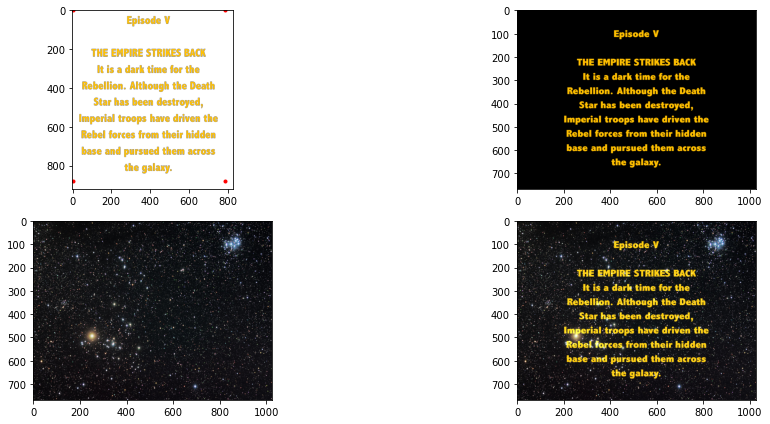

In [24]:
#idea: transform shape of text image as same as galaxy image then add them together

hg,wg,cg = bg_image.shape
ht,wt,ct = text_image.shape

src = np.array([[0, 0], [0, round(hg/1.2)], [round(wg/1.5), 0], [round(wg/1.5), round(hg/1.2)]])#target
dst = np.array([[0, 0], [0, ht], [wt, 0], [wt, ht]])#orgin

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(text_image, tform3, output_shape=(round(hg/1.2), round(wg/1.5)))
hw, ww, cw = warped.shape
#print(warped.shape)
#why 4 channels after warp?????

padded = bg_image.copy()
#zero-padding in order to keep beautiful margin
for i in np.arange(cg):
    padded[:,:,i] = np.pad(warped[:,:,i], (((hg-hw)//2, hg-(hg-hw)//2-hw),
                                           ((wg-ww)//2, wg-(wg-ww)//2-ww)),
                           'constant',constant_values=((0,0),(0,0)))

starwars = bg_image+padded
starwars = np.where(starwars>1, 1, starwars)


fig, ax = plt.subplots(2,2, figsize=(16, 6))

ax[0,0].imshow(text_image, cmap=plt.cm.gray)
ax[0,0].plot(dst[:, 0], dst[:, 1], '.r')
ax[0,1].imshow(padded, cmap=plt.cm.gray)

ax[1,0].imshow(bg_image, cmap=plt.cm.gray)
ax[1,1].imshow(starwars, cmap=plt.cm.gray)

plt.tight_layout() 


## 6 Segmentation